# Imports and Constraints

# Defines

In [63]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import category_encoders as ce


def load_data() -> pd.Series:
    csv = pd.read_csv('train.txt', sep=" ")
    percentage0 = round(len(csv[csv["class"]==0])/len(csv)*100,2)
    percentage1 = round(len(csv[csv["class"]==1])/len(csv)*100,2)
    classes = csv['class']
    csv = csv.drop(['class'], axis=1)
#     print(f"class0: {percentage0}%,\tclass1: {percentage1}%")
    return csv, classes

def del_nans(nans_perc):
    # Find those where nans is over nans_perc
    global csv, nans
    na = csv.isna().sum()
    del_na = na[na >= nans_perc*len(csv)]
    csv = csv.drop(del_na.index.values, axis=1)
    nans = nans_ctr()
    
def nans_ctr() -> pd.Series:
    return csv.isna().sum()

def unique_ctr() -> pd.Series():
    unique = pd.Series()
    for col in list(csv):
    #     len(csv[col].unique().astype(int))
    #     print(f"col {col}\t unique: {len(csv[col].unique())}")
        unique.at[col] = len(csv[col].unique())
#     print(unique.head(5))
    return unique

def val_types() -> pd.Series():
    val_type = pd.Series()
    for col in list(csv):
        if csv[col].dtype == np.float64:
            val_type.at[col] = np.float64
        elif csv[col].dtype == np.int64:
            val_type.at[col] = np.int64
        elif csv[col].dtype == object:
            val_type.at[col] = object
        else:
            print("No common value type found in val_types()")
#     print(f"float: {sum(val_type == np.float64)}")
#     print(f"int: {sum(val_type == np.int64)}")
#     print(f"string: {sum(val_type == object)}")
    return val_type

def stat(f):
    nans = nans_ctr()
    unique = unique_ctr()
    val_type = val_types()
    print(f"nans: {nans[f]}")
    print(f"unique: {unique[f]}")
    print(f"val_type: {val_type[f]}")
    print(f"vals per class: {round((len(csv)-nans[f])/unique[f],2)}")
    
def plot(data, sort=False, log=True, small=False):
    if small:
        figsize = (8,4)
    else:
        figsize = (20,10)
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    if sort:
        df.sort_values(by=0, ascending=False).plot(kind='bar', logy = log, figsize=figsize, legend=False)
    else:
        df.plot(kind='bar', logy = True, figsize=figsize, legend=False)
    
def threshold_factorization(data, *t_list) -> pd.Series():
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df = df.sort_values(by=0, ascending=False)
    t_list = (df.values[0].item()+1,) + t_list + (0,)
    out = data.copy()
#     print(f"all labels: {len(letter_counts)}")
    for i in tqdm(range(1,len(t_list)),desc="Progress",leave=False):
        idx = df[(df>t_list[i]).values & (df<=t_list[i-1]).values].index
#         print(f"labels in range ({t_list[i]}, {t_list[i-1]}): {len(idx)}")
        for j in tqdm(idx,leave=False):
            out.loc[out == j] = i
    return out

def factorize(data) -> pd.Series():
#     series = data.fillna(-1)
    series = data.copy()
    labels, _ = pd.factorize(series)
    series = labels[:len(series)]
    return series

def cast(data, lower_t, upper_t) -> pd.Series():
#     print(f"Casting with max , min = ({lower_t},{upper_t})")
    data = data.sort_values()
    data[data<lower_t] = lower_t
    data[data>upper_t] = upper_t
    return data

def standarize(df) ->pd.Series():
    return round((df-df.min())/(df.max()-df.min()),4)

def one_hot_encoding(f):
    global csv
    ohe = ce.OneHotEncoder(cols = [f], handle_unknown='ignore', use_cat_names=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)
    
def binary_encoding(f):
    global csv
    ohe = ce.BinaryEncoder(cols = [f], handle_unknown='ignore',drop_invariant=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)  

# Template

In [25]:
f = 'Var'
# csv[f] = csv_org[f].fillna(-8)
print(f"Val Type:{val_type[f]}\nNans: {nans[f]}\nunique: {unique[f]}")
# csv[f] = cast(csv[f],-100,64)
# threshold_factorization(csv[f],1000,100,1)
# csv[f] = standarize(csv[f])
# csv[f] = factorize(csv[f])
# plot(csv[f].sort_values(),small=True)
# one_hot_encoding(f)

KeyError: 'Var'

# Data Cleaning

In [66]:
csv,classes = load_data()
nans = nans_ctr()
unique = unique_ctr()
val_type = val_types()
print(max(nans))
del_nans(0.99)
print(max(nans))
print(len(csv.columns))
csv_org = csv.copy()

40000
39558
206


# Data Preprocessing

In [65]:
f = 'Var1'
csv[f] = csv_org[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,64)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

KeyError: 'Var1'

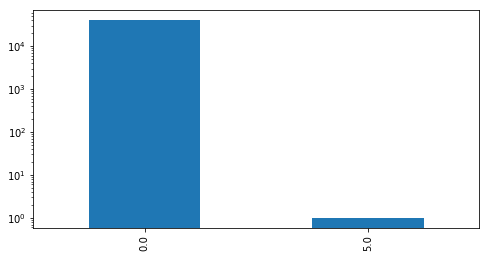

In [39]:
f = 'Var2'
csv[f] = csv_org[f].fillna(csv[f].mode(dropna = True)[0])
one_hot_encoding(f)
plot(csv[f].sort_values(),small=True)

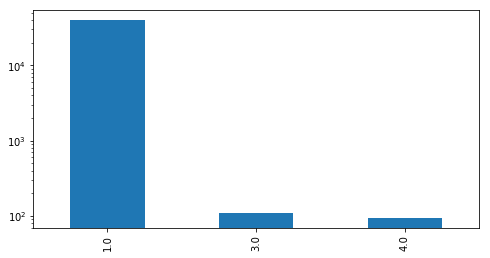

In [47]:
f = 'Var3'
csv[f] = csv_org[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = threshold_factorization(csv[f],1000,100,1)
one_hot_encoding(f)
plot(csv[f].sort_values(),sort=True,small=True)

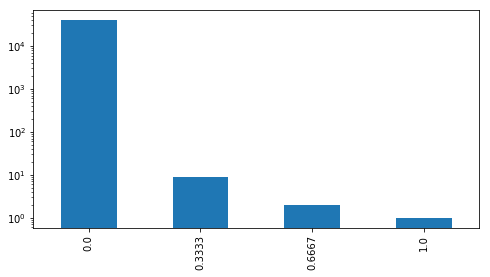

In [67]:
f = 'Var4'
csv[f] = csv_org[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

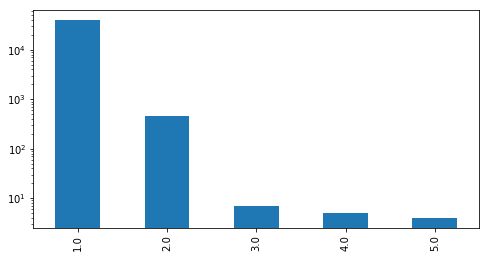

In [46]:
f = 'Var5'
csv[f] = csv_org[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = threshold_factorization(csv[f],1000,7,5,4,2,1)
binary_encoding(f)
plot(csv[f],sort=True,small=True)

Val Type:<class 'numpy.float64'>
Nans: 4397
unique: 1363


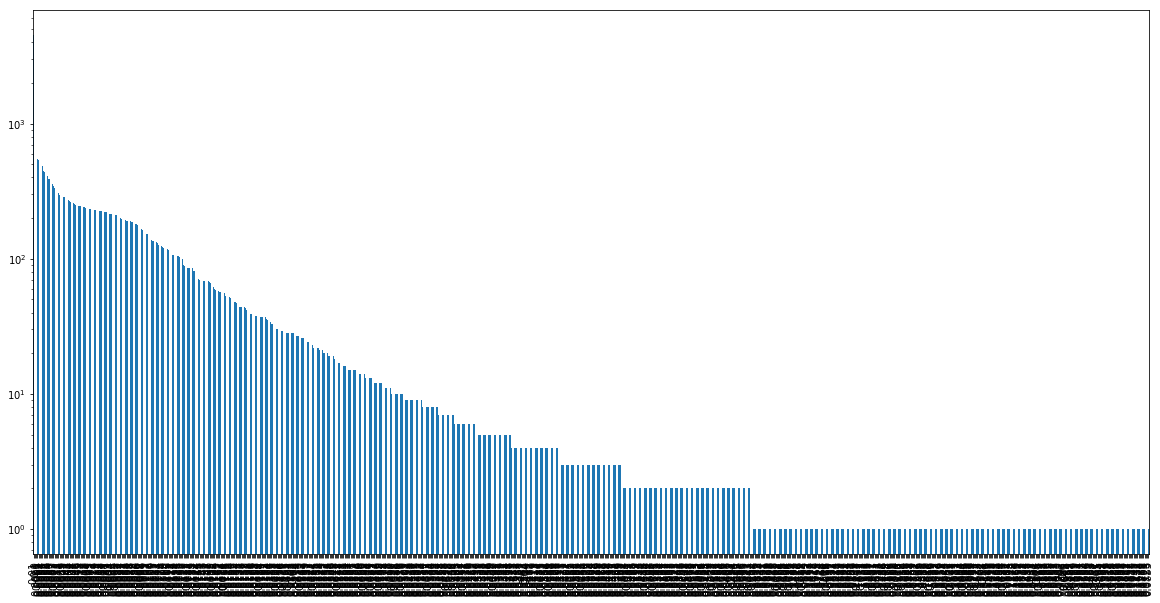

In [272]:
f = 'Var6'
csv[f] = csv_org[f].fillna(round(csv[f].mean(),4))
csv[f] = standarize(csv[f])
plot(csv[f],sort=True)

Val Type:<class 'numpy.float64'>
Nans: 4409
unique: 9


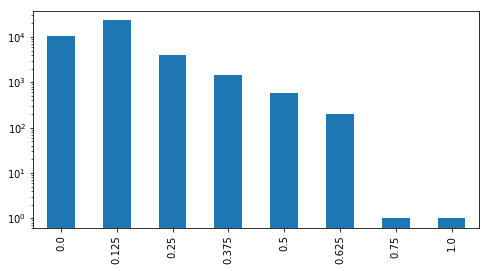

In [268]:
f = 'Var7'
csv[f] = csv_org[f].fillna(7)
csv[f] = cast(csv[f],-100,56)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

In [22]:
f = 'Var9'
# csv[f] = csv_org[f].fillna(-8)
stat(f)
# csv[f] = cast(csv[f],-100,64)
# threshold_factorization(csv[f],1000,100,1)
# csv[f] = standarize(csv[f])
# csv[f] = factorize(csv[f])
# plot(csv[f].sort_values(),small=True)
# one_hot_encoding(f)

No common value type found in val_types()
No common value type found in val_types()
nans: 39431
unique: 95
val_type: <class 'numpy.float64'>
vals per class: 5.99


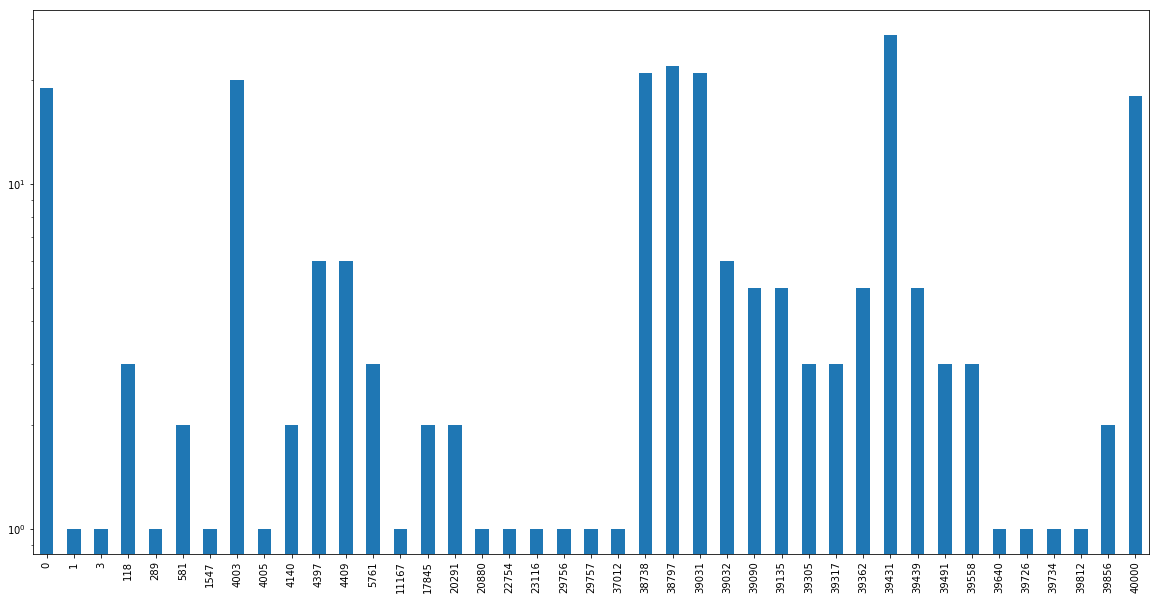

In [52]:
plot(nans.sort_values())

In [217]:
val_type.to_csv(r'C:\Users\Mateusz\Desktop\val_types.txt', header=None, index=None, sep=' ', mode='a')

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [ ]:

# print(unique.sort_values().values)
# print(nans.values)